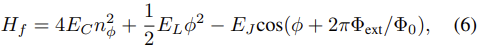


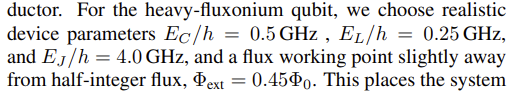

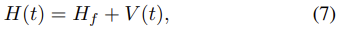

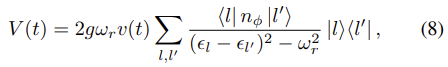

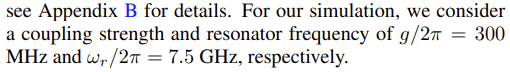

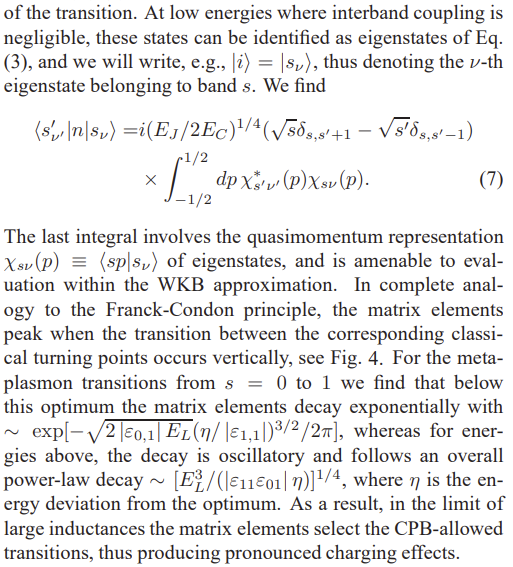

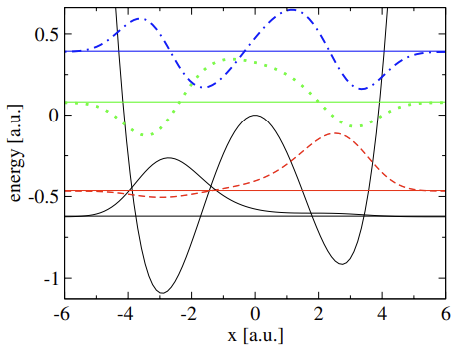

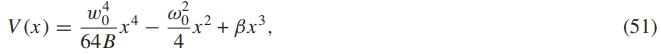

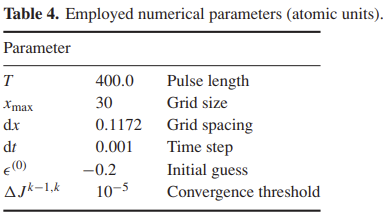

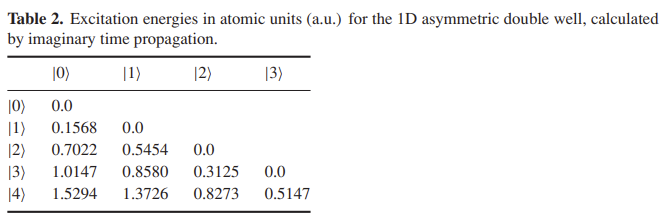

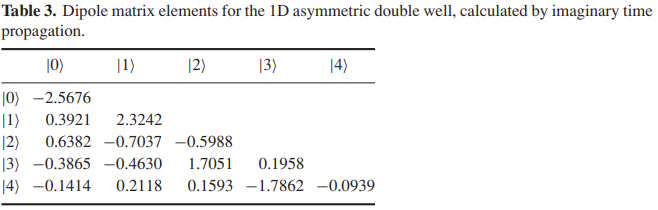

# Numerically solve the Fluxonium Hamiltonian

In [1]:
import QM as qm
import numpy as np
import matplotlib.pyplot as plt

In [2]:
30/0.1172

255.9726962457338

In [3]:
L = 15
N = 256
x = np.linspace(-L,L,N)
dx = 2*L/(N-1)

In [4]:
EC = 0.5 #Ghz
EL = 0.25
EJ = 4.0
PhiExt = 0.45 #Phi0

omega_0 = 1
beta = 1/256
B = 1
def V(x):
    #return np.zeros(len(x))
    #return -10*x + np.exp(x)
    
    return (omega_0*x)**4/(64*B) - (omega_0*x)**2/4 + beta*x**3
    #return 0.5*EL*x**2 - EJ*np.cos(x + 2*np.pi*PhiExt)
    
Potential_energy = np.diag(V(x))
#Kinetic_energy = -4*EC/dx**2*(np.diag(-2*np.ones(N)) + np.diag(np.ones(N-1),1) + np.diag(np.ones(N-1),-1))
Kinetic_energy = -1/(2*dx**2)*(np.diag(-2*np.ones(N)) + np.diag(np.ones(N-1),1) + np.diag(np.ones(N-1),-1))

H = qm.operator(Kinetic_energy + Potential_energy)
eigval, eigvec = H.eig()

In [5]:
# tmp = np.zeros((N,N))
# tmp[([0,-1],[-1,0])] = 1

# H = qm.operator(np.diag(V(x)) -4*EC/dx**2*(tmp+np.diag(-2*np.ones(N)) + np.diag(np.ones(N-1),1) + np.diag(np.ones(N-1),-1)))
# eigval, eigvec = H.eig()

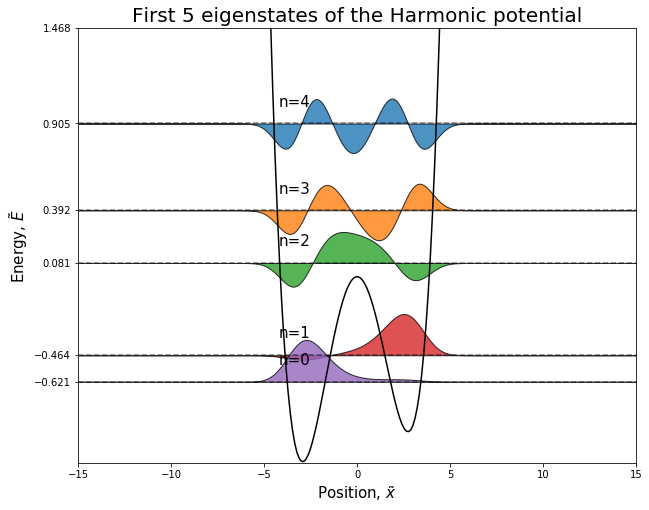

In [9]:
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(x,V(x),'k')
xmin,xmax = -L,L
# ymin,ymax = -3.2,10
ymin,ymax = -1.1,0.6
for i in range(4,-1,-1):
    ax.fill_between(x,eigvec[i]+eigval[i],[eigval[i] for _ in x],label='n=%d'%i,edgecolor='k',alpha=0.8)
    ax.text(-4.2,eigval[i]+0.1,'n=%d'%i,fontsize=15)
    ax.hlines(eigval[i],xmin,xmax,linestyle='--',alpha=0.5)
ax.set_ylim(ymin,ymax)
ax.set_xlim(xmin,xmax)
# ax.legend()
ax.set_title("First 5 eigenstates of the Harmonic potential",fontsize=20)
ax.set_yticks(eigval[:6])
ax.set_xlabel('Position, $\\tilde{x}$',fontsize=15)
ax.set_ylabel('Energy, $\\tilde{E}$',fontsize=15)
plt.show()

# P operators:

$$ \frac{d\psi(x_n)}{dx} \approx \frac{\psi(x_{n+1}) - \psi(x_{n-1})}{2\Delta x}$$

In [110]:
diff_x = (np.diag(np.ones(N-1),1) - np.diag(np.ones(N-1),-1))/(2*dx)
p_operator = qm.operator(-1j*diff_x)
p_operator

operator([[0.-0.j   0.-4.25j 0.-0.j   ... 0.-0.j   0.-0.j   0.-0.j  ]
          [0.+4.25j 0.-0.j   0.-4.25j ... 0.-0.j   0.-0.j   0.-0.j  ]
          [0.-0.j   0.+4.25j 0.-0.j   ... 0.-0.j   0.-0.j   0.-0.j  ]
          ...
          [0.-0.j   0.-0.j   0.-0.j   ... 0.-0.j   0.-4.25j 0.-0.j  ]
          [0.-0.j   0.-0.j   0.-0.j   ... 0.+4.25j 0.-0.j   0.-4.25j]
          [0.-0.j   0.-0.j   0.-0.j   ... 0.-0.j   0.+4.25j 0.-0.j  ]])

In [111]:
qm.ket(eigvec[0]).H*p_operator*qm.ket(eigvec[0])

-2.1197732156165748e-17j

In [112]:
qm.ket(eigvec[1]).H*p_operator*qm.ket(eigvec[1])

1.3507061443181456e-17j

In [114]:
2.3242/2.5676, (1.3507061443181456/2.1197732156165748)

(0.9052033026951237, 0.6371937027826197)

# Proceed by following the "Quantum Optimal Control Theory" pdf

In [136]:
import qutip as qp
import matplotlib.pyplot as plt
import numpy as np
import torch as t
from tqdm import tqdm

In [104]:
(eigval[:5]-eigval[0])

array([0.        , 0.15681053, 0.70178086, 1.01307053, 1.52556064])

In [316]:
energies = np.array([0,0.1568,0.7022,1.0147,1.5294])

H0 = np.diag(energies)
V = np.array([[-2.5676,0.3921,0.6382,-0.3865,-0.1414],
              [0.3921,2.3242,-0.7037,-0.4630,0.2118],
              [0.6382,-0.7037,-0.5988,1.7051,0.1593],
              [-0.3865,-0.4630,1.7051,0.1958,-1.7862],
              [-0.1414,0.2118,0.1593,-1.7862,-0.0939]])

H0 = t.tensor(H0)
V = t.tensor(V)
identity = t.diag(t.ones(5,dtype=t.complex128))

T=100
n_steps = 1000
times = t.linspace(0,T,n_steps)
dt = T/n_steps
exp_H0 = t.matrix_exp(-0.5j*H0*dt)


def evolve(epsilon):
    U=identity
    for e in epsilon:
        tmp = t.matrix_exp(-1j*e*V*dt)
        U = t.matmul(U,t.matmul(exp_H0,t.matmul(tmp,exp_H0)))
    return U

In [317]:
Psi0 = t.tensor([[1],[0],[0],[0],[0]],dtype=t.complex128)
Psi_target = t.tensor([[0],[1],[0],[0],[0]],dtype=t.complex128)

def loss_func(PsiT):
    return 1 - t.abs(t.matmul(t.adjoint(Psi_target),PsiT)).squeeze()
    #diff = Psi_target - Psi0
    #return t.real(diff)**2 + t.imag(diff)**2

epsilon = t.nn.parameter.Parameter(t.tensor(np.ones(n_steps)))
#epsilon = t.nn.parameter.Parameter(t.tensor(tmp))
epsilon.to(device)

cut = t.nn.parameter.Parameter(t.tensor(T,dtype=t.float))
cut.to(device)

PsiT = t.matmul(evolve(epsilon*t.sigmoid(10*(cut-times))),Psi0)

In [318]:
loss = loss_func(PsiT)
optimizer = t.optim.Adam([epsilon,cut],lr=1e-2)
loss.backward()
optimizer.step()

print(f"Initial loss: {loss}")

N = 1
#with tqdm(total=1000) as pbar:
while loss >=0.001 and N<=1000:
    optimizer.zero_grad()
    PsiT = t.matmul(evolve(epsilon*t.sigmoid(10*(cut-times))),Psi0)
    loss = loss_func(PsiT)
    loss.backward()
    optimizer.step()
    N += 1
    pbar.update(1)
    print(loss.item(), N, end='\r')
print(N)

Initial loss: 0.9661310386568474
810009451182262347757 81


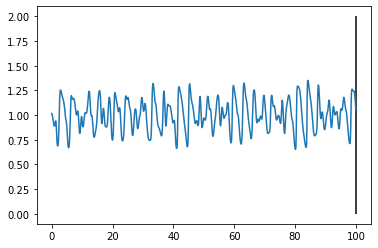

In [319]:
fig, ax = plt.subplots()

ax.plot(times,epsilon.detach())
ax.vlines(cut,0,2)

In [321]:
loss, PsiT

(tensor(0.0009, dtype=torch.float64, grad_fn=<RsubBackward1>),
 tensor([[ 0.0018+0.0172j],
         [ 0.9988+0.0241j],
         [ 0.0300+0.0156j],
         [-0.0068+0.0062j],
         [-0.0144+0.0127j]], dtype=torch.complex128, grad_fn=<MmBackward0>))

C:\Users\jv97\anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  """


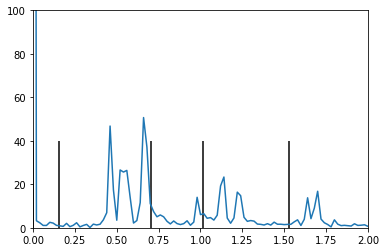

In [325]:
tmp = epsilon.detach().numpy()

fig, ax = plt.subplots()

ax.plot(np.linspace(0,1/dt,(times<cut).sum()//2+1),np.abs(np.fft.rfft(tmp[times<cut])))
ax.set_ylim(0,100)
ax.set_xlim(0,2)
ax.vlines(energies,0,40)

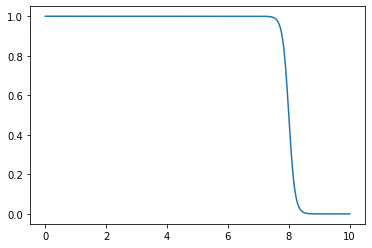

In [268]:
fig, ax = plt.subplots()
xes = np.linspace(0,10,1000)
ax.plot(xes,t.sigmoid(t.tensor((8-xes)*10)))
